### Key points of the projects

1. **Robotarium Simulation Environment:** The code is designed to simulate the behavior and control of robots in a simulated environment using the Robotarium platform.
2. **Formulation of the control problem:** The problem involves controlling the movement of robots to reach certain goal points while avoiding predefined hindering points. The goal is to find an optimal control policy for the robots.
3. **Dynamics Modeling:** The **`model_step`** function simulates the dynamics of the robots in the environment. Updates robot positions based on their current positions, speed and the specified time interval.
4. **Cost Function and State Cost:** The **`state_cost`** function defines the cost associated with the state of the robots, which includes the distance to the goal points and the proximity to the predefined obstacle points. It also includes a Gaussian component to account for the limits of the environment.
5. **Control Step and Policy Sampling:** The **`Control_step`** function is responsible for generating the optimal action for the robot based on a control policy. It uses a probability density function and samples actions to control the movement of the robots.
6. **Optimization:** The code involves solving a convex optimization problem to learn the cost associated with different states. Use the CVXPY library to optimize the weight of the cost function.
7. **Visualization:** The code includes various visualization components to show robot trajectories, cost map, and feature points with their weights.

### Tools to use

1. **Robotarium Library:** The code takes advantage of the Robotarium library to simulate the behavior of robots in a controlled environment. It provides functionality to define initial conditions, configure simulation, and visualize robot trajectories.
2. **NumPy and SciPy:** NumPy is used to perform efficient numerical calculations and array operations, while SciPy is used for statistical operations, particularly for generating multivariate Gaussian distributions.
3. **CVXPY Library:** The CVXPY library is used to solve convex optimization problems. It provides a high-level interface for defining and solving convex optimization problems, which is critical for learning the cost associated with different states in the control problem.
4. **Matplotlib:** Matplotlib is used for data visualization and graphing. It is used to display robot trajectories, cost map, and feature points with their weights. Matplotlib is a widely used library for plotting in Python, known for its versatility and ease of use.
5. **Pandas:** Pandas is used for data manipulation and analysis. It helps organize and process data for the cost map, making it easier to analyze and visualize the reconstructed cost map.

In [1]:
import rps.robotarium as robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *

import numpy as np
import scipy.stats as st
import time

In [2]:
#Defining the input axes
# Note: the boundaries for the control actions are the actuation constraints imposed by the physics of the robots

control_space_size = 3  # Three possible inputs for each control axis

U_space_1 = np.array(np.linspace((-0.5),(0.5),control_space_size))  #[-0.5  0.   0.5] First spatial dimension of the Robotarium simulation environment
U_space_2 = np.array(np.linspace((-0.5),(0.5),control_space_size)) # [-0.5  0.   0.5] Second spatial dimension of the Robotarium simulation environment
time_step = 0.033 # Robotarium time-step (from the documentation) 

In [3]:
# This function performs a "model" step using the documented dynamics
# Note: from the viewpoint of the controller the dynamics is not necesarily known

# This function executes a "model" step using the documented dynamics.
# Takes as input the current position x, the speeds and the time interval time_step.
# Update the position of the robots by calculating the new coordinates as the sum of the current coordinates and the product
# between the time interval and the respective speeds along the x and y directions. Returns the new updated coordinates as a
# array of size (2,1).
def model_step(x,velocities,time_step):
    """_summary_
Args:
         x (float): current position of the robot
         velocities (float): robot speed
         time_step (_type_): time interval to execute a model step
    """
    poses = np.zeros((2,1))
    # Update pose of the robots
    poses[0] = x[0] + time_step*velocities[0]
    poses[1] = x[1] + time_step*velocities[1]
    return(poses)

#Get the value of a Gaussian pf at a given point ?
#This function calculates the value of a Gaussian probability density function (PDF) at a specific point.
# Takes as input the evaluation point x, the mean value of the Gaussian distribution u and the covariance matrix covar.
# The function starts by calculating the k dimension of the point x. Then calculate some intermediate steps using the transposed values,
# the inverse of the covariance matrix and the difference between the point x and the mean value u. Next, calculate the numerator and the
# denominator of the multivariate Gaussian distribution formula and returns the value of the Gaussian PDF at that specific point.
# In this case the function in question is a multi-variate Gaussian to calculate the value of the probability density at a point
def my_logpdf(x, u, covar): 
    """_summary_

    Args:
        x (float): PDF evaluation point
        u (float): average PDF value
        covar (float): PDF covariance matrix

    Returns:
        float: pdf obtained from the sampled data
    """
   # Calculate the size of the vector
    k = len(x)  # dimension 
   # Calculates the difference between the evaluation point x and the mean value u of the Gaussian distribution, then takes its transpose
    a = np.transpose(x - u) 
    #Calculate the inverse of the covariance matrix
    b = np.linalg.inv(covar) 
   #Calculate the difference between the evaluation point x and the average value u.
    c = x - u 
   #Perform matrix multiplication between a and b.
    d = np.matmul(a, b) 
  #Perform matrix multiplication between d and c.
    e = np.matmul(d, c)
   #Calculate the numerator of the Gaussian distribution formula. 
    numer = np.exp(-0.5 * e)
   #Calculate the constant term of the denominator.
    f = (2 * np.pi)**k 
    g = np.linalg.det(covar) 
   #Calculate the denominator of the Gaussian distribution formula.
    denom = np.sqrt(f * g) 
    #Calculate the value of the multi-variate Gaussian probability density function (PDF) based on the previously calculated numerical values
    pdf = numer / denom 
    #f(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
    #myLogpdf = \log f(x) = -\frac{1}{2} \log 2\pi - \log \sigma - \frac{(x-\mu)^2}{2\sigma^2}
    return pdf 





# WP0

In [4]:
##### WP0: formalize the control problem #####



### **Direct Problem Statement:**

The direct problem in this context is to determine the optimal control action for a robot operating in a constrained environment. The goal is to find the most effective control inputs that allow robot to reach certain goal points while avoiding obstacles. This problem can be formulated as the search for the optimal policy or control strategy that minimizes a defined cost function. The main components of the directed problem statement are as follows:

1. **Goal**: Minimize a defined cost function, which includes terms related to distance to objective points, obstacle avoidance, limits of the environment and possibly other factors that influence control behavior.
2. **Constraints**: Implementation constraints based on the physical limitations of the robots, as well as any environmental constraints to be considered during the optimization process.
3. **Control Inputs**: Represent the possible actions that robots can take in the specified control space. Control inputs directly influence robot trajectories and movements.

### **Inverse Problem Statement:**

The inverse problem, on the other hand, involves inferring the underlying cost function based on observed data, such as the robots' trajectories and their interactions with the environment. The goal is to reconstruct the cost function that best explains the behavior of the robots during the control process. The main components of the inverse problem statement include:

1. **Observations**: The trajectories and movements of the robots, with their interactions with the goal points and obstacles, constitute the main data for inferring the cost function.
2. **Parameter Estimation**: The task consists in estimating the parameters of the cost function based on the observed data. This could include identifying weights associated with different cost components, such as goal attainment, obstacle avoidance, or other relevant factors that influence the robot's behavior.
3. **Cost Function Optimization**: The inferred cost function must be optimized to ensure that it accurately captures the dynamics of the control problem. This involves refining the parameters of the cost function to match the observed behavior of the robots as closely as possible.

Problem set up
============

Let $ \mathbb{X_k} ∈  \mathbb{X} ⊆  \mathbb{K^n}$ be the system state at time step k and $ \mathbb{U_k} ∈  \mathbb{U} ⊆  \mathbb{K^p}$ be the control input at time step k. Time indexing is chosen so that the system switches to $x_k$ when $u_k$ is applied. That is, making the standard Markovian assumption, the possibly nonstationary and nonlinear stochastic dynamics for the system under control is described by the pf $p(x) := p(x) (x_k | u_k,x_{k−1})$. We will call this pf as target pf.

To formalize the control problem we introduce the pf:
 $p_{0:N} =p_0(x_0)\Pi(p_{k|k−1}) =p_0(x_0)\Pi(p^{(x)}_{k|k-1}*p^ {(u)}_{k|k-1})$\
 where: $p^{(u)}_{k|k−1}:= p_{(u)}(u_k | x_{k−1})$ is a randomized policy and the initial conditions are incorporated via the prior $p_0(x_0)$.
Furthermore, we use the shorthand notation $p^{(x)}_{k|k−1}p^{(u)}_{k|k−1}=p(x_k,u_k|x_{k-1} )$

Furthermore, let us remember that the pf $p_{0:N}$ describes in probabilistic terms the evolution of the closed-loop system when, at every k, a given
policy, let's say $p_k^{(u)}(u_k|x_{k-1})$ is used.
With the forward control problem formalized next we aim to design the policy. This policy is then exploited to address the inverse problem where we try to estimate the cost.

## Forward control problem
Let $c_k :  \mathbb{X} →  \mathbb{R}$ be the cost, at time step k, associated with a given state $x_k$. Then, the expected cost incurred when the system is in state $x_{k−1}$ and input $u_k$ is applied is given by $\mathbb{E}_{p_{k|k-1}^{(x)}}[c_k(X_k )]$ . The advanced control problem considered in this file is formalized with the following:

Given a pdf joint: $q_{0:N} := q_0 (x_0) \Pi q^{(x)} (x_k | u_k, x_{k−1}) q_k^{(u)} (u_k | x_ {k−1})$ find the pdf sequence ${p_{k|k-1}^{(u)}}^*$ such that ${p_{k|k-1}^{(u)} }^*_{1:N}\space \in arg\space min{D_{KL}(p_{0:N}||q_{0:N}+\sum  \mathbb{E}_{\tilde p_{k- 1: k}}[ \mathbb{E}_{p_{k|k-1}^{(x)}}c_k(X_k)])}$ with the following constraint: ${p_{k|k-1}^{(u)} }\space \space \in  \mathbb{D} \space \space \forall \space \mathbb{k} \space \in  \mathbb{\Gamma}$. where $ \tilde p_{k−1:k} := p_{k−1}(x_{k−1}, u_k)$

## Inverse control problem
The inverse control problem we consider consists of estimating the cost-to-go for the agent, say $\tilde c_k(·)$, and the agent's cost $c_k(·)$ given a set of states/inputs observed samples from $p^{(x)}_{k|k-1}$ and the agent's policy. In what follows, we denote by $\hat x_k$ and $\hat u_k$ the observed state and control input at time step k.
Regarding the IOC we also consider that the cost-to-go is expressed as a linear combination of the features. It can be expressed as $ \tilde p(x_k)=-w_k^Th(x_k)$, where $[h_1(x_k).....h_f(x_k)]^T$ is the feature vector and $h_i: \mathbb{X}\rightarrow \mathbb{R}$ are known functions, with $i=1....f$ and $w_k=[w_{k,1}....w_{k,f}]^T $ is a vector of weights.

## A special case
### FOC

We note that in our case the KL-divergence component in the cost resulted from the following problem: $p_{0:N} =p_0(x_0)\Pi(p_{k|k−1}) =p_0(x_0)\Pi(p^{(x)}_{k|k-1}*p^{(u)}_{k|k-1})$ becomes an entropic regulator and consequently the optimal policy from the softmax function $p_{k|k-1}^{(u)}=\frac{\tilde p^{(u)}_{k|k-1}exp (-E_{p_{k|k-1}}[\tilde c(X_k)])}{\sum_{u_k}(\tilde p^{(u)}_{k|k-1}exp (-E_{p_{k|k-1}}[\tilde c(X_k)]))} $ becomes $p_{k|k-1}^{(u)}=\frac{exp(-E_{p_{k|k-1}}[\ln(\tilde p^{(u)}_{k|k-1})+\tilde c(X_k))]}{\sum_{u_k}exp(-E_{p_{k|k-1}}[\ln(\tilde p^{(u)}_{k|k-1})+\tilde c(X_k))]} $ where $c_k$ is given by the natural logarithm of the expected value of the summation of the exponentials having as argument the expected value calculated on policy p of state x at time k+1 given k of the natural logarithm of policy p added to the expected cost at time k+1 of the state relative to the time instant k+1, all changed in sign. Furthermore, in this particular configuration of the FOC the previously mentioned expected value is equal to 0.
### IOC
In the IOC the problem becomes: $argmin\{\sum_{k=1}^M(-\mathbb{E}_{p(x_k|\hat x_{k-1},\hat u_K)}[w_k^Th(x_k)]) +\ln (\sum _{u_k} exp(\mathbb{E}_{p(x_k|\hat x_{k-1},u_k)}[-\ln p(x_k|\hat x_{k-1},u_k])+w_k^Th(x_k)\}$

State_cost function

In [5]:
# Task: reverse engineer the cost function used by the robots. What is the problem formulation? 
#      Is the one below a good cost for the task? Create a heatmap to visualize the cost 

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)
    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi))) 

    return(cost)

### Monte Carlo sampling approach
The following function for executing the "step" of the algorithm uses a sampling approach called the "Monte Carlo (MC) sampling approach". This is a statistical technique used to obtain numerical estimates of quantities that are complex or difficult to calculate directly. The fundamental idea of MC is to generate random samples from a known (or approximate) probability distribution to estimate desired properties or quantities. In the context of the underlying control handover algorithm the Monte Carlo sampling approach is used to obtain control actions based on a probability distribution defined by the Kullback-Leibler (DKL) divergence probabilities and the cost estimate.
The basic steps are described below:

1) Generation of Future States: The algorithm generates possible future states of the system by applying different combinations of control commands (U_space_1 and U_space_2) to the state transition function (model_step).

2) Calculating Approximated DKL and Estimated Cost: For each possible future state, calculate a cost estimate using the state_cost_estimated function and the approximate Kullback-Leibler divergence.

3) Generation of Kullback-Leibler Divergence Probabilities: Use the results obtained to construct a Kullback-Leibler divergence probability (pf) matrix.

4) Monte Carlo Sampling: Sample from this probability distribution to obtain a control action. In practice, this means that the control actions are chosen randomly, but the probability of selecting a specific action is influenced by the Kullback-Leibler divergence and the cost estimate.

5) Normalization of the Probability Distribution: Ensures that the obtained probability distribution is valid by normalizing it.

The Monte Carlo sampling approach is particularly useful when probability distributions are complex or difficult to model analytically. Using sampling, numerical estimates of desired distributions and quantities can be obtained. This type of approach is commonly used in optimization, machine learning, and simulation contexts, where it is necessary to explore the solution space stochastically to find good candidates or make precise predictions. 


# WP1

Control_step

In [6]:
##### WP1: fill-in the code for the function below.
#         The function needs to return the optimal action sampled from the optimal policy.
#         The action is used in the simulation loop #####
#The Control_step code after the tasks now calculates the value of the log_DKL based on the given formula and normalizes the pf matrix based on S2.
# Next, the code performs appropriate sampling from the multidimensional pf to obtain the desired action.
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf Inizializzazione della target pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf 
        for i in range(control_space_size):
            for j in range(control_space_size):
                # Task: what do the next three lines do?
               # The next step is calculated thanks to the previously defined "model_step" function, based on the current state characterized by U_space1 and U_space2 and the time_step of the Robotarium environment.
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step) 
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]]) # defines a covariance matrix for the multivariate normal distribution.
                f = st.multivariate_normal(next_state.reshape((2,)),cov)  #creates a multivariate normal distribution based on the next calculated state and the defined covariance matrix
                # Task: what do the next two lines do?
                N_samples = 20 #initialization of the number of random samples that will be generated by the multivariate normal distribution.
                 # Thanks to the "rvs" function we generate the N_samples random samples from the multivariate normal distribution.
                 # The random samples represent the possible subsequent states of the system under study, used to calculate the cost and the estimate of the optimal policy.
                next_sample = f.rvs(N_samples) 

                # Task: what do the next three lines do?
                cost=0 #initialization of the cost variable subsequently calculated at the null value, i.e. the minimum one
                for k in range(N_samples): #scrolling through all previously generated samples
                    #the costs calculated for all the previously generated samples are averaged, allowing us to calculate the average cost over the N_samples.
                    cost+=state_cost(next_sample[k,:],goal_points,obs_points)/N_samples  

                # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy
                log_DKL = np.exp(-(-f.entropy())-cost) #since the target function is uniform, minimizing the divergence corresponds to maximizing the entropy.
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        # Task: obtain the normalizer for the policy, call it S2
        S2 = np.sum(pf)  
        # Task: obtain the normalized pf (call the variable pf)
        pf = np.divide(pf,S2) 

        # This is a trick to properly sample from the multi-dimensional pf
        flat = pf.flatten()#transform multidimensional array to dimensional array

        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)

## Discuss how the solution compares to the other methods seen in class (without coding)
In general, we can compare the technique used FOC with the other techniques seen in the course following some points:

- Stationary cost: clearly, KLC requires a stationary cost while FOC does not, just like FDP and tracking do not require it.

- Efficient computation: the winning point of KLC is precisely to make the computation of the optimal policy efficient, provided certain assumptions are respected. In the case of FOC, the policy we use is greedy because the computational complexity due to dynamic programming at the core of the cost-to-go calculation could explode. This last consideration also applies to FPD. Regarding tracking, however, the computational cost is a question mark, as we indeed need to use dynamic programming, but we also only need to compose the policies, so we are somewhat in the middle, and this depends only on the type of data we have available.

- Discrete/continuous spaces: KLC exists for discrete spaces but also for continuous ones, the same goes for FOC and FPD. However, KLC for continuous spaces becomes more onerous, still better than probabilistic control but it becomes more heavy compared to the discrete version.

- Stationary policy: in KLC, what we obtain as a result is a stationary policy, while this is not true for FOC, FPD, and tracking. From a practical point of view, this is not negligible, as it is much simpler to maintain a stationary policy in a computer rather than one that needs to be updated at every time instant.

- Cost-to-go calculation: For the calculation of the cost-to-go, we use linearization in the case of KLC, while for FOC, FPD, and tracking, we need to resort to dynamic programming.
Sample data constraint: KLC is not constrained to sample data; the dynamics can be passive or extracted from other simulations, and this is inherited in tracking and also applies to FOC. FPD, on the other hand, requires having sample data available.

### FPD
Let's analyze the advantages and disadvantages of FPD:

Strengths:

- We can collect data on a system different from the one we want to control.
- This technique inherently accepts noise because it is built on it, so the system can be nonlinear, stochastic, time-varying (non-stationary): we have not made any assumptions except for the Markov assumption.
- There is an explicit solution; we don't necessarily have to solve the optimization problem, assuming it would be convex and thus not difficult to solve.


Weaknesses:

- Computational cost: we have only used a greedy policy.
- We have assumed that the example dataset covers all operational conditions.
- A control algorithm that solves this problem cannot synthesize new behaviors but can only imitate. So, we say it "copies" only what the example dataset does.
Moreover, if there is no data for a certain window, and in the case under consideration, we have no data for any window, we might consider using a uniform density instead of the example density. However, if we use a uniform density, the Kullback-Leibler divergence becomes entropy. So, if we then maximize entropy, it means maximizing the disorder of our solution, and the robot would move erratically. To compensate for this, we must include a cost in our formulation. If we have a cost, we can afford to have a non-informative density because there is a cost that makes us perform the control task.
For the control task, it was considered essential to relax the requirements on the dataset (since we don't have one) and equally important, in case we have one, to go beyond the behaviors seen in the example dataset. To address this, we can add a cost function to the target that depends only on the state and must capture the control task. However, this is precisely the formalization of Forward Optimal Control, which appears to be much more aligned with our goals. Having no information about a possible passive dynamics or a reference dynamics, we could use a probability function that is as uninformative as possible, pretending that we don't know anything, namely a uniform probability function. This means that I really don't know how to choose. In this situation, our problem takes on a max entropy formulation that increases the disorder of the data distribution, favoring exploration but always keeping in mind the control task captured by the cost.

### Tracking

Regarding tracking, only a comparison with the key aspects previously discussed has been made since, lacking primitives to "schedule," the results cannot be effectively evaluated. However, in the event that such primitives are available, it is believed that this technique can likely prove to be an appropriate choice for the given problem.

### Other methods
The comparison with other methods and additional reasons concerning the choice of Forward Optimal Control and Inverse Optimal Control will be provided and detailed in the report.

In [7]:
"""
Definition of the goal_points, i.e. the objective or destination points that the robots must reach during the control process and the obs_points, i.e. the points representing the obstacles or areas 
to avoid within the environment in which the robots move. Robots must avoid colliding with obs_points and must choose paths that minimize the risk of interacting with them. 
In the cost function, the distance of the robots from the "goal_points" is an important factor that affects the overall value oFOCf the cost. Instead, the proximity of the robots to the "obs_points" 
contributes to increasing the overall value of the cost, since it represents a penalty for approaching dangerous or unwanted areas.
"""
#caso base
goal_points = np.array(np.mat('-1.4; -0.8; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) 

# Define goal and obstacle points
#15
#goal_points = np.array(np.mat('-0.8; -0.8; 0'))
#obs_points = np.array(np.mat('-0.5 -0.5 -0.5 -0.5 -1.2;0.2 0.4 0.6 0.8 -0.3;0 0 0 0 0')) 
#8
#goal_points = np.array(np.mat('1.3; 0.8; 0'))
#obs_points = np.array(np.mat('-0.0 -0.0 -0.0 -0.0 0.0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) 
#3
#goal_points = np.array(np.mat('-1.0; 0.3; 0'))
#obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) 

### Heatmap del costo

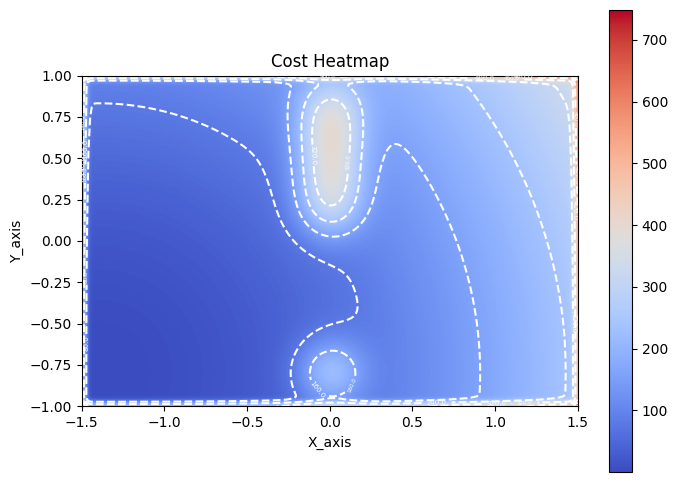

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Initialize a matrix to store the cost values
cost_matrix = np.zeros((300, 200))
X = np.linspace(-1.5, 1.5, 300)
Y = np.linspace(-1, 1, 200)

# Calculate the cost for each point in the grid
for i in range(200):
    for j in range(300):
        state = [X[j], Y[i]]
        cost_matrix[j, i] = state_cost(state, goal_points, obs_points)

# Create a DataFrame for the cost matrix
Cost_Map = pd.DataFrame(cost_matrix, index=list(X), columns=Y)

# Transpose the data for correct orientation in the heatmap
data_rotated = np.transpose(Cost_Map)

# Create a heatmap of the cost values
plt.figure(figsize=(8, 6))

# Display the heatmap
plt.imshow(data_rotated, extent=[X.min(), X.max(), Y.min(), Y.max()],
           origin='lower', cmap='coolwarm')
plt.colorbar()

# Add contour lines to the heatmap
contours = plt.contour(X, Y, data_rotated, levels=10, colors='white', linestyles='dashed')

# Label the contour lines with values
plt.clabel(contours, inline=True, fontsize=4, fmt='%1.1f')

# Customize the contour labels
plt.clabel(contours, inline=True, fontsize=5, fmt='%1.1f')

# Add axis labels and a title
plt.xlabel('X_axis')
plt.ylabel('Y_axis')
plt.title('Cost Heatmap')

# Display the plot
plt.show()


### 3D Cost Visualization

<Figure size 2000x1000 with 0 Axes>

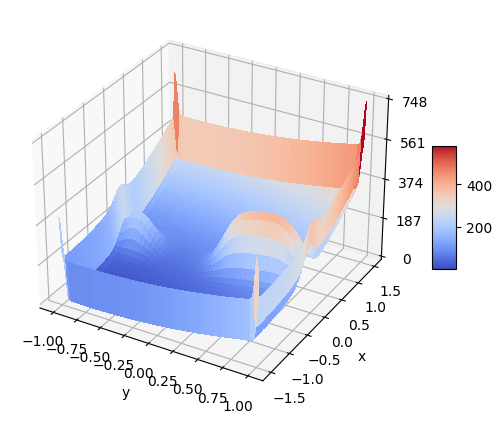

In [9]:
import matplotlib.pyplot as plt  # Importing the Matplotlib library for plotting
from matplotlib import cm  # Importing the color map module from Matplotlib
from matplotlib.ticker import LinearLocator  # Importing the LinearLocator module from Matplotlib
import numpy as np  # Importing NumPy library for numerical operations

fig = plt.figure(figsize=(20, 10))  # Creating a new figure with a specified size
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})  # Creating a 3D subplot within the figure
fig.figure.set_figheight(20)  # Setting the figure height

X_axis = np.linspace(-1.5, 1.5, 300)  # Generating X-axis values
Y_axis = np.linspace(-1, 1, 200)  # Generating Y-axis values
X, Y = np.meshgrid(Y_axis, X_axis)  # Creating a meshgrid for X and Y values

# Plotting the surface using the Cost_Map values with specified colormap and properties
surf = ax.plot_surface(X, Y, Cost_Map, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customizing the z-axis properties
# ax.set_zlim(-1.01, 1.01)  # Uncomment and customize if needed
ax.zaxis.set_major_locator(LinearLocator(5))  # Setting major locator for the z-axis
ax.zaxis.set_major_formatter('{x:.0f}')  # Setting major formatter for the z-axis

ax.set_xlabel('y')  # Labeling the x-axis
ax.set_ylabel('x')  # Labeling the y-axis

# Uncomment and customize if needed
# ax.view_init(90, 0)  # Setting the view angle for the 3D plot

# Adding a color bar to the plot
fig.colorbar(surf, shrink=0.08, aspect=5)

plt.show()  # Displaying the plot
# plt.savefig('Cost_Map_estimated.jpg', dpi=1000, bbox_inches='tight')  # Uncomment to save the plot as an image file


From a careful analysis of the heatmap we see that the cost function tends to take on higher values in correspondence with the presence of obstacles. This cost function considers the square of the Euclidean distance between the current robot position (its state) and the final arrival position, proportioning the value of the cost function based on the value of the latter. Furthermore, this cost function also takes into account the presence of obstacles thanks to the presence of the gauss_sum term (note that the obstacles are modeled as Gaussians) and finally also takes into account the presence of some critical areas for the robot, i.e. the boundary areas, present in the extreme areas of the heatmap.
By virtue of this we can deduce from this first analysis that it is a good cost function due to the fact that take into account all the crucial aspects of the control task.

# WP2

In [10]:
#WP2: Simulate (4 experiments) and visualize each robot's trajectory

## Simulation

We proposed various initial conditions in addition to those provided for which simulations of the robotarium algorithm are carried out to ensure that the robot converges towards the desired goal_point.

In [11]:
# Initial conditions of the robot for 4 experiments
#initial_conditions is characterized by a 4X3 matrix where each row represents the initial position. Each position is characterized by 3 components they represent
#the initial position along the respective x and y axes including the position of the thetha angle, which would be the angle perpendicular to the wheel axis.
#This shape is called "hand position and in our case they are of the type: [1.4,0.9],[0.2,0.9],[1.2,-0.5],[-1,0.9]" all with equal theta angle to 0.
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))] #Initial pose of the robots


In [12]:
initial_conditions = [np.array(np.mat('-1.4;0.4; 0')),np.array(np.mat('0.0;-0.4; 0')),np.array(np.mat('-1.0;0.1; 0')),np.array(np.mat('1;0.4; 0'))] #Initial pose of the robots

Esperimento

In [13]:
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('1.2;0.2; 0')),np.array(np.mat('-1.2;0.8; 0')),np.array(np.mat('1.3;-0.9; 0')),np.array(np.mat('1.3;0.25; 0')),np.array(np.mat('-0.1;0.9; 0'))] #Initial pose of the robots

In [14]:
#initial_conditions = [np.array(np.mat('1.4;-0.8; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))] 

In [15]:
#initial_conditions = [np.array(np.mat('1.4;-0.8; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))] 

In addition to various simulations with different initial conditions, others were also carried out with different goal_points to further highlight some critical issues of the cost function provided to us.

In [16]:
#goal_points = np.array(np.mat('-1.0; 0.4; 0')) 

In [17]:
#goal_points = np.array(np.mat('-1.0; 0.8; 0')) #Critical case because the algorithm does not converge.

In [18]:
#goal_points = np.array(np.mat('-1.0; 0.6; 0')) #Problems with the orange trajectory, the robotarium does not converge with the latter

In [19]:
#goal_points = np.array(np.mat('-1.0; 0.4; 0'))

Through the following cell we will perform various experiments thanks to the Robotarium tool

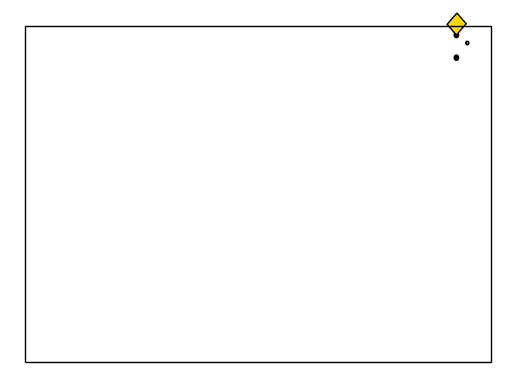

##### DEBUG OUTPUT #####
Your simulation will take approximately 34 real seconds when deployed on the Robotarium. 

	 Simulation had 920 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

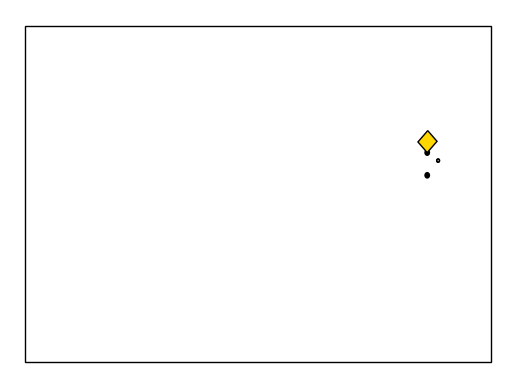

##### DEBUG OUTPUT #####
Your simulation will take approximately 40 real seconds when deployed on the Robotarium. 

	 Simulation had 1958 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

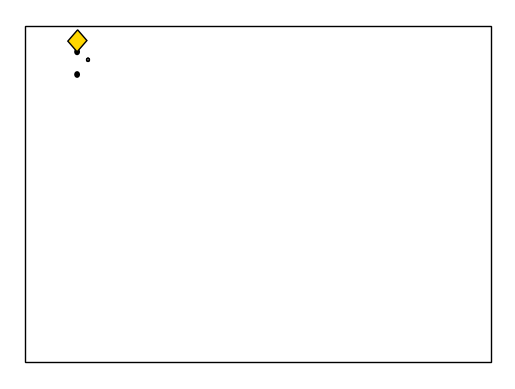

##### DEBUG OUTPUT #####
Your simulation will take approximately 28 real seconds when deployed on the Robotarium. 

	 Simulation had 2658 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

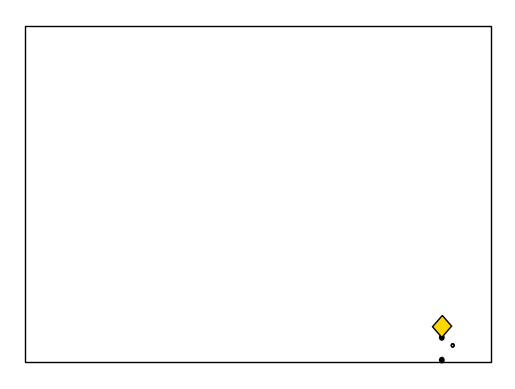

##### DEBUG OUTPUT #####
Your simulation will take approximately 42 real seconds when deployed on the Robotarium. 

	 Simulation had 3777 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

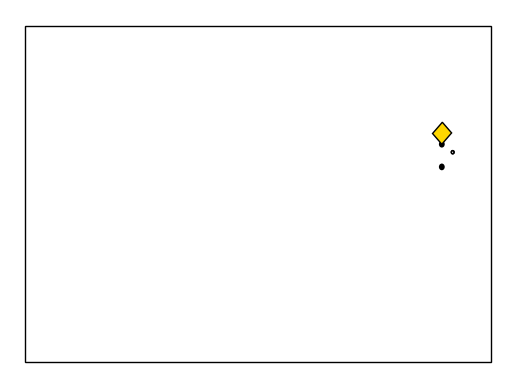

##### DEBUG OUTPUT #####
Your simulation will take approximately 44 real seconds when deployed on the Robotarium. 

	 Simulation had 4937 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

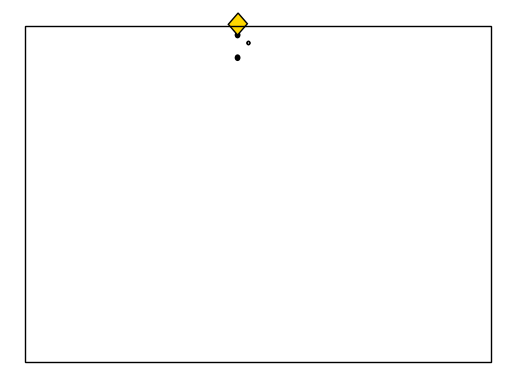

##### DEBUG OUTPUT #####
Your simulation will take approximately 34 real seconds when deployed on the Robotarium. 

	 Simulation had 5839 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

In [20]:
# Instantiate Robotarium object
N = 1 #Amount of robots per simulation

#numbers of experiments
N_experiment = 6
# X_si is going to be two-dimensional state history
X_Si = [0]*N_experiment
# D_Xi is going to be two-dimensional inputs history
D_Xi = [0]*N_experiment

# This first for loop creates the initial conditions
for I in range(N_experiment):

    #represents the set of system states (position, orientation) for each time step during the execution of the control algorithm.
    X_si = []
   #This variable represents the set of control actions (inputs) for each time step during the execution of the control algorithm.
    D_xi = []

    #the following function takes as input the number of robots to enter into the simulation of the Robotarium environment, a parameter which
     #indicates whether a figure representing the position of the robot, a vector of initial conditions, should be shown on the video as output
     #and a parameter indicating whether the simulation should run in real time or not.
    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

    # Create mapping from the control inputs to the actual velocity commands to the unicycle
    # Note: this is a very practical situation (robots often provide transformation functions to low level commands)
    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion() #Converts single integrator inputs to unicycle inputs (low-level controller)
    _, uni_to_si_states = create_si_to_uni_mapping()
    
    # define x initially
    x = r.get_poses()
    x_si = uni_to_si_states(x)

    # Plotting Parameters
    CM = np.random.rand(N+10,3) # Random Colors
    goal_marker_size_m = 0.15
    obs_marker_size_m = 0.15
    marker_size_goal = determine_marker_size(r,goal_marker_size_m)
    marker_size_obs = determine_marker_size(r,obs_marker_size_m)
    font_size = determine_font_size(r,0.1)
    line_width = 5

    # Create Goal Point Markers
    #Text with goal identification
    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    #Plot text for caption
    goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(goal_points.shape[1])]
    goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
    for ii in range(goal_points.shape[1])]

    #Text with goal identification
    obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    #Plot text for caption
    obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(obs_points.shape[1])]
    obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
    for ii in range(obs_points.shape[1])]

    r.step()
    # While the robot is away from the objective ...
    # with the following while loop the actual simulation of the Robotarium begins. A general stopping condition will be used as the condition of the while loop.
    # In particular, the while loop will continue to run the simulation as long as the number of robots that are in position near the goal_point
    # will be different from the total number of robots in the simulation environment. That is, in other words, iterates until all the robots in the simulation
    # reach the goal point (in the case in question it is only one).
    i=0
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N and i<10000):
        # Get poses of agents
       #The pose of the agents is taken. 
        x = r.get_poses()
       #Current state of the system
        x_si = uni_to_si_states(x)

        #Add to the dataset
        X_si.append(x_si) # X_si represents the state history for the I-th experiment

        # The lines below define the pdf of the robot 
       #covariance of the robot's pdf. Specifies how much uncertainty is present in the system's movements.
        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]]) 
       #represents a normal multivariate probability distribution (PDF) based on the current state of the system
        x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov) 
        x_sample = x_pdf.rvs() #Noisy state

        # This is about plotting
       #For plotting, markers are set for both goal points and obstacle points.
        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

        for j in range(obs_points.shape[1]):
            obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

        # Task: compute the action from the policy. Call the variable dxi: 
        # this is the action sampled from the optimal solution to the control problem
        # The following variable represents the control action (input) for a specific time step during the execution of the control algorithm.
        dxi = Control_step(x_sample,U_space_1,U_space_2,goal_points,obs_points)

        D_xi.append(dxi) # D_xi represents the history of control inputs for the I-th experiment.

        # Transform single integrator velocity commands to unicycle inputs (low level controller)
        # The following function takes as input the control action (input) for a specific time step during the execution of the control algorithm and
        # the state of the system (position, orientation) for a specific time step during the execution of the control algorithm.
        dxu = si_to_uni_dyn(dxi, x)

        # Set the velocities inputs
        # We set the speeds, do the step and save some history for plotting later.
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        i=i+1
        r.step()
    # The following variable represents the history of control actions (input) for all N_experiments.
    D_Xi[I] = D_xi
    # The following variable represents the history of the system states for all N-experiments.
    X_Si[I] = X_si

    #Call at end of script to print debug information and for your script to run on the Robotarium server properly
   #Line that creates a script.
    r.call_at_scripts_end()

Le seguenti cella serve per preparare le variabili per il plotting

### Trajectories Plot

In [21]:
XX = X_Si
UU = D_Xi

In [22]:
# Prepare data for plotting
X = []      # Initialize an empty list to store X values
X_plot = [] # Initialize an empty list to store X_plot values
U = []      # Initialize an empty list to store U values
U_plot = [] # Initialize an empty list to store U_plot values

# Iterate through each element in XX
for i in range(len(XX)):
    X.append(np.array(XX[i]))      # Append each element of XX as a NumPy array to X
    X_plot.append(np.array(XX[i])) # Append each element of XX as a NumPy array to X_plot

# Concatenate the list of NumPy arrays in X along axis 0 (row-wise) and reshape into a 2D array
X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))

# Initialize an empty list to store U values
U = []

# Iterate through each element in UU
for i in range(len(UU)):
    U.append(np.array(UU[i]))      # Append each element of UU as a NumPy array to U
    U_plot.append(np.array(UU[i])) # Append each element of UU as a NumPy array to U_plot

# Concatenate the list of NumPy arrays in U along axis 0 (row-wise) and reshape into a 2D array
U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))


Text(0, 0.5, 'Y [m]')

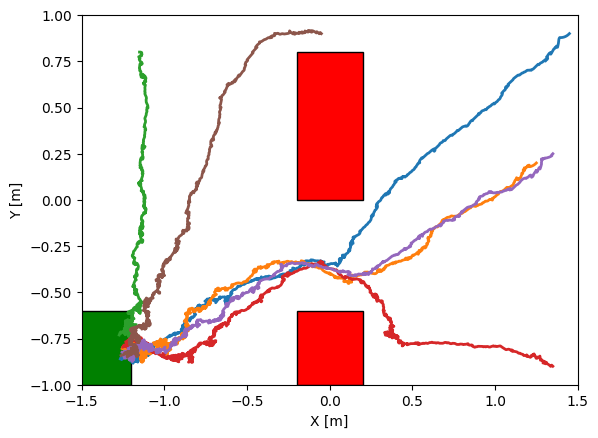

In [23]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np


plt.plot(X_plot[0][:,0],X_plot[0][:,1],linewidth=2)
plt.plot(X_plot[1][:,0],X_plot[1][:,1],linewidth=2)
plt.plot(X_plot[2][:,0],X_plot[2][:,1],linewidth=2)
plt.plot(X_plot[3][:,0],X_plot[3][:,1],linewidth=2) 
plt.plot(X_plot[4][:,0],X_plot[4][:,1],linewidth=2)
plt.plot(X_plot[5][:,0],X_plot[5][:,1],linewidth=2)

square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black")
square3 = plt.Rectangle((-0.2,-1), 0.4, 0.4, fc='red',ec="black")
square2 = plt.Rectangle((-0.2,0), 0.4, 0.8, fc='red',ec="black")

plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]') 
plt.ylabel('Y [m]')

### Combined Visualization of cost surface and trajectories

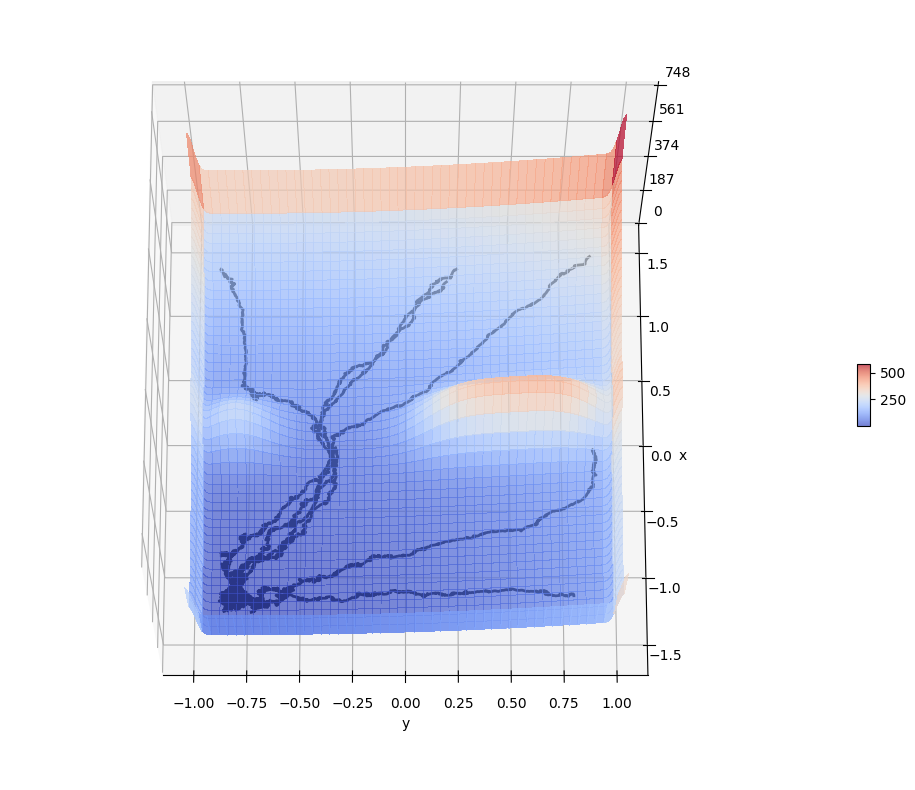

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np



fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

X_axis = np.linspace(-1.5, 1.5, 300)
Y_axis = np.linspace(-1, 1, 200)
X_surface, Y_surface = np.meshgrid(Y_axis, X_axis)

surf = ax.plot_surface(X_surface, Y_surface, Cost_Map, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.7)

for i in range(len(X_plot)):
    Z_surface = np.zeros_like(X_plot[i][:, 0])  
    ax.plot(X_plot[i][:, 1], X_plot[i][:, 0], Z_surface, linewidth=2, color='black')

ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter('{x:.0f}')
ax.set_xlabel('y')
ax.set_ylabel('x')

ax.view_init(elev=70, azim=-90)  

fig.colorbar(surf, shrink=0.08, aspect=5)

plt.show()


### Simple GUI for visualizing cost surface and trajectories

From the following plot we can see that using the cost function provided, the robot manages to reach the goal_point while avoiding the obs_points even starting from various different initial conditions. However, there are critical situations for which the robot is unable to converge towards the goal_point and this happens when the initial condition of interest is close to the obstacle or when we have a start_point that starts from one side of the obstacle and the goal point on the opposite side. In this situation the algorithm remains stuck in a local minimum (situation that occurs when the robot and the goal point are aligned along a coordinate), and consequently never converges towards the optimal solution (the robotarium cell even after hours execution ends).

# WP3

In [25]:
##### WP3: Reverse engineer the features and visualize them #####


In [26]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))

After having reverse engineered the features, the parameters on which the subsequent considerations in the analysis of the function will be based are listed below.
- **Relevance:** Features must appropriately capture critical aspects of the robot's environment, such as proximity to the goal and obstacles. This relevance ensures that the robot makes decisions based on its circumstances.
- **Scalability:** The ability of the function to handle different numbers of features effectively and to adapt to various obstacle configurations or environmental complexity is crucial. The scalability of the set of features is essential for its applicability in different scenarios.
- **Sensitivity to Parameters:** The choice of parameters, such as the covariance matrix, which is used to define the statistical dispersion of the random variables involved in the calculation of the features, and the distance metric, can significantly influence the calculations of the features. Therefore, it is essential to carefully tune these parameters to ensure that the characteristics accurately reflect the robot's goals.
- **Adaptability:** Features should be adaptable to changes in the environment or dynamic obstacles. A robust set of features should enable the robot to respond effectively to dynamic changes, ensuring smooth and efficient navigation even in uncertain or evolving environments.

The function calculates a set of features based on the Gaussian probability density function, calculated using the **`my_logpdf`** function. Each feature represents the probability density function of the state with respect to specific points, including target points and obstacles. Here are the key points for critical analysis:

1. **Proximity to Goal Feature (Feature 0):** The first feature measures the Euclidean distance between the current state and the target points. This feature encourages the robot to minimize the distance to the target, promoting convergence to the desired position. In the case of a unicycle robot, it is crucial to have information about the distance to the goal to guide the robot's behavior in the correct direction.
2. **Obstacle Proximity Features (Feature 1 to N):** These features represent the probability density of the state with respect to each obstacle point. The function calculates the multivariate Gaussian probability density function for each obstacle point, using a predefined covariance matrix. This allows the robot to evaluate its proximity to obstacles and avoid approaching them. By including obstacles in the feature set, the function penalizes the robot for being near or moving towards these points.
3. **Adaptable design choices:** The flexibility of the feature, with the N_feature parameter representing the number of features, is particularly useful. This allows you to easily add or remove features depending on the robot's specific navigation requirements.
4. **Adaptability to different obstacle and goal configurations:** The function is designed to be adaptable to different obstacle and goal configurations. This is important in dynamic scenarios where the layout of obstacles can vary over time.

At least in a first analysis (obviously we have to test whether the reconstructed cost allows the task to be completed), we can say that the feature vector is consistent with the objectives of the task; it does not depend excessively on specific circumstances, therefore, it should also present a certain level of robustness with respect to variations in the environment and the dynamics of the system; furthermore, although the number of features is not high, it still seems to present a sufficient level of informativeness for the problem under consideration (motion planning). Following what has been stated, it can be considered that the features are good candidates for solving the inverse control problem.


features(next_state, goal_points,obs_points N_feature) = my_logPDF[$\frac{1}{\sqrt{2\pi}\sigma} exp\left(-\frac{1}{2\sigma^2}(x - \mu)^2\right)$]

### Features

In [27]:

# Task: reverse engineer the features and critically discuss them
#np.size calculates the number of columns of the obs array.
#The number of features is determined by the size of the obs_points_f array
N_feature = np.size(obs_points_f,axis=1)+1 #represents the total number of features considered in the "feature" function.
#This parameter is important because it determines the size of the array that stores the features calculated for the robot's next state.
# The N_feature variable allows you to dynamically manage the number of features to consider in the context of the robot control problem and can be adjusted as needed
# application specific. It plays a crucial role in determining the complexity of the features considered in the "feature" function and allows dynamic adaptation
# the number of attributes based on the specific context and objectives of robot control.

#This "feature" function is used to calculate and return a feature vector based on the robot's next state, goal points, and obstacle points.
def feature(next_state,goal_points,obs_points,N_feature): #>vector h()
    """summary

    Args:
        next_state (type): next state of the robot 
        goal_points (type):  target points
        obs_points (type): obstacle points
        N_feature (type): number of features

    Returns:
        array:returns the feature array, which contains the distance to the goal as the first feature and the values of the probability density functions for each obstacle point as subsequent features.
   """
    v = np.array([0.025, 0.025], dtype=np.float32) #initializes an array v containing variance values for creating the covariance matrix for the multivariate normal distribution.
    covar = np.diag(v) #generate the covariance matrix using the newly created array v.
    features = np.zeros(N_feature)#initializes an array of zeros with a size equal to the number of features N_feature.
     # calculate the my_logpdf function for each obstacle point, and update the corresponding elements in the features array.  
    for i in range(np.size(obs_points,axis=1)): 
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar) 
        # features for each obstacle point.
    # Calculation of Euclidean distance between next_state and goal_points
    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) 
    
    
    return features 

# WP4

In [28]:
##### WP4: using the previously defined features solve the inverse optimal control problem. 
#          Plot the estimated cost. 
#          Verify that the estimated cost allows the robot to complete the task #####

The provided code solves a convex optimization problem to learn cost function weights using the cvxpy library

In [29]:
%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
#The size of dataset X (robot states) is calculated, subtracting 1 to get the number of instances
M = np.size(X,axis=0) - 1
#The variable w, optimization variable of (1,N_feature), is defined as a vector of weights to be optimized. 
w = cp.Variable((1,N_feature)) 
#we set the constraint that the weights w must be greater than or equal to zero.
constraints = [w >= 0]
#Some arrays necessary for solving the optimization problem are initialized
R = np.zeros((99,1))
L = []
# Initialize arrays for results and expectations
f_expect = np.zeros((2,20))
feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((control_space_size,control_space_size,M))
#A loop is executed on each data instance(robot states). Inside the loop, several quantities are calculated, including the Kullback-Leibler (DKL) divergence,
# the sampled features and the expected features. Next, a log-likelihood term is formulated for each instance (l) and added to a list L.
# Loop through each data instance
for i in range(M):
    #############################################################################################################################
    # Calculate features and expectations
   #initialization of the feature vector
    features = np.zeros((N_feature,control_space_size,control_space_size))
    #a vector is defined to store the variable that takes into account the state of the robot 
    state = np.array(X[i,:]) #Get the state
    #manipulation of the variable that takes into account the initial state
    x0 = state.reshape(-1,1)
   #initialize time_step to default value
    time_step = 0.033


    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
    # Nested loop to compute features and Kullback-Leibler divergence probabilities
    for j in range(control_space_size):
        for k in range(control_space_size):
            #using the model_step function to compute the next state
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
           #covariance calculation: The element in position (0, 0) (first row, first column) is 0.001, representing the variance of the first variable.
             # The element in position (1, 1) (second row, second column) is 0.001, representing the variance of the second variable.
             # The elements in position (0, 1) and (1, 0) (first row, second column and vice versa) are both 0.0002, representing the covariance between the two variables.
             #We refer to two variables because the state takes into account two variables being two-dimensional.
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            #calculation of the multivariate normal
            f = st.multivariate_normal(next_state.reshape((2,)),cov) 
            next_sample = f.mean

            N_samples = 5
            #N_samples random samples are generated from the multivariate normal
            next_samples = f.rvs(N_samples)
            #initialization of the feature vector
            feature_sample = np.zeros((N_feature,N_samples))

            #features are calculated for each sample
            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature)

            features[:,j,k] = np.mean(feature_sample,axis=1)

            # Calculate Kullback-Leibler divergence probability
            log_DKL = np.exp(-(-f.entropy()))
            pf[j,k] = log_DKL
    PF[:,:,i] = pf
    #feature manipulation
    features = np.reshape(features,(N_feature,control_space_size**2))

    f_sampled = model_step(state,U[i+1,:],time_step)
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    # Calculate features for sampled state
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)
    

    # # Task: solve, using cvx the convex optimization problem we saw in class. To do so:
    # # (i) prepare each individual term of the summation, say l;
    # # # (ii) sum all the elements to define the cost function
    # # # (iii) solve the problem
    # Calculate log-likelihood term for each instance and add to the list L
    l = -(w @ feature_sampled[:,i]) + cp.log_sum_exp(cp.reshape(w @ features,(control_space_size,control_space_size)) + cp.log(PF[:,:,i]))
    #PF[:,i] is a vector representing the probability density function of the target distribution.
     # this line of code calculates the difference between the expected and sampled values of the features multiplied by the weights, along with the probability density function of the target distribution.
     # The result represents the quantity that must be minimized in the optimization problem.
    L.append(l) #Log likelihood for each instance
#The objective function is defined as the sum of the log-likelihoods for each instance. 
# Define the objective as the sum of log-likelihood terms
objective = cp.Minimize(cp.sum(L))
# Create an optimization problem
prob = cp.Problem(objective)
# Solve the optimization problem
result = prob.solve(verbose = False)

# Print optimization results
print("status:", prob.status)
print("optimal value", prob.value)

In [30]:
# Show the values: critically discuss if these weights make sense
weights = w.value
print('weights:',weights)

weights: [[-10.55918633  -5.88813546   0.06122433  -0.10752713 -29.63097558
   -1.64362482  -0.25611223   0.97722992   0.06121903   0.07608011
   -1.37930089   0.03648148   0.18754716   0.32328708  -0.14330092
    0.72963197]]


For the analysis of the weights the following points will be observed:

1. **Sign of Weights:** Most of the weights are negative, indicating that the model is assigning a negative impact to the characteristics considered. The model tends to penalize these characteristics in estimating the cost function.

2. **Magnitude of Weights:** The magnitude of weights varies greatly, with some weights being very large in absolute value. For example, the first two weights are an order of magnitude higher than the others. This suggests that these two characteristics have a significant impact on the cost function. It is assumed that in this phase those weights are related to features that must discourage the function from approaching obstacles.

3. **Consistency with Expectations:** Since we are in the context of optimization of the IOC in the case of the unicycle robot we can expect negative weights, as they must not encourage the function to converge in certain configurations of the space which are those of obstacles

4. **Experiments and Validation:** Subsequently, to validate the validity of our analysis we will perform an in-depth analysis of the reconstructed cost function.

In [31]:
# Check the status of the optimization problem: did the optimization go well?
print("status:", prob.status)
print("optimal value", prob.value)

status: optimal
optimal value -13230.918941340391


In the following code the original cost map will be reformatted, useful for plotting purposes.

In [32]:
# Reformatting the original cost map (just for checking and plotting purposes)

import numpy as np  # Importing NumPy library for numerical operations
import scipy.stats as st  # Importing SciPy's stats module for statistical functions
import pandas as pd  # Importing Pandas library for data manipulation and analysis

goal_points = np.array(np.mat('-1.4; -0.8; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) 

def state_cost(state, goal_points, obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)  # Defining a 2D array of variances
    covar = np.diag(v)  # Creating a diagonal covariance matrix using variances

    gauss_sum = 0  # Initializing a variable to store the sum of Gaussian components

    for i in range(np.size(obs_points, axis=1)):  # Looping through obstacle points
        gauss_sum += 20 * my_logpdf(state[:2], obs_points[:2, i], covar)  # Accumulating Gaussian components

    cost = 30 * ((state[0] - goal_points[0]) ** 2 + (state[1] - goal_points[1]) ** 2) + gauss_sum  # Computing the total cost
    return cost

Cost_Map = np.zeros((300, 200))  # Initializing a 2D array to store the cost map
X_axis = np.linspace(-1.5, 1.5, 300)  # Generating X-axis values
Y_axis = np.linspace(-1, 1, 200)  # Generating Y-axis values

for i in range(200):
    for j in range(300):
        state = np.array([X_axis[j], Y_axis[i]])  # Creating a state vector based on X and Y values
        Cost_Map[j, i] = state_cost(state, goal_points, obs_points)  # Computing the cost for each grid point

Coat_Map = pd.DataFrame(Cost_Map, index=list(X_axis), columns=Y_axis)  # Creating a DataFrame with the computed cost map


In [33]:
# Computing the reconstructed cost map

import numpy as np  # Importing NumPy library for numerical operations
import scipy.stats as st  # Importing SciPy's stats module for statistical functions

goal_points = np.array(np.mat('-1.4; -0.8; 0'))

def state_cost_estimated(state, goal_points, obs_points, weights):
    v = np.array([0.025, 0.025], dtype=np.float32)  # Defining a 2D array of variances
    covar = np.diag(v)  # Creating a diagonal covariance matrix using variances

    gauss_sum = 0  # Initializing a variable to store the sum of Gaussian components

    for i in range(np.size(obs_points, axis=1)):  # Looping through obstacle points
        gauss_sum += -weights[:, i + 1] * my_logpdf(state[:2], obs_points[:2, i], covar)  # Accumulating Gaussian components

    # Computing the total cost based on estimated weights
    cost = -weights[:, 0] * (((state[0] - goal_points[0]) ** 2 + (state[1] - goal_points[1]) ** 2)) + gauss_sum
    return cost

Cost_Map = np.zeros((300, 200))  # Initializing a 2D array to store the reconstructed cost map
X_axis = np.linspace(-1.5, 1.5, 300)  # Generating X-axis values
Y_axis = np.linspace(-1, 1, 200)  # Generating Y-axis values

for i in range(200):
    for j in range(300):
        state = np.array([X_axis[j], Y_axis[i]])  # Creating a state vector based on X and Y values
        Cost_Map[j, i] = state_cost_estimated(state, goal_points, obs_points_f, weights)  # Computing the cost for each grid point


### Reconstructed Cost Heatmap

/var/folders/h8/_fxskz7s2_j0ywzp2t4cqg900000gn/T/ipykernel_23339/1897867411.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticklabels)
/var/folders/h8/_fxskz7s2_j0ywzp2t4cqg900000gn/T/ipykernel_23339/1897867411.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


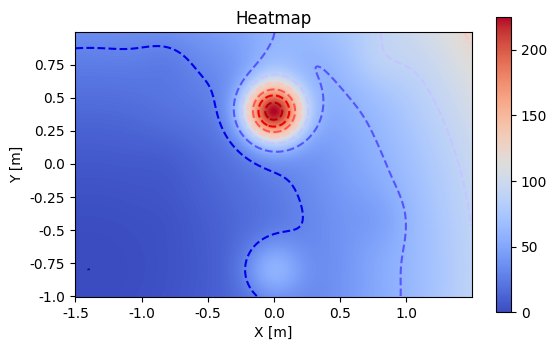

<Figure size 640x480 with 0 Axes>

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Transpose the data array to rotate the heatmap
data_rotated = np.transpose(Cost_Map)

# Task: plot the reconstructed cost
# Create a figure and axes
fig, ax = plt.subplots()

# Create a heatmap using imshow()
heatmap = ax.imshow(data_rotated,cmap='coolwarm')

contours = ax.contour(data_rotated,cmap='seismic' , linestyles='dashed')

# Add a colorbar
cbar = plt.colorbar(heatmap,shrink=0.8)

# Add labels and title
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Heatmap')

ax.invert_yaxis()

# Define the desired tick positions and labels for x and y axes
x_ticklabels = np.arange(-2, 2, 0.5)  # Example: custom tick labels for x-axis
y_ticklabels = np.arange(-1.25, 1.25, 0.25)  # Example: custom tick labels for y-axis

# setta asse x e y
ax.set_xticklabels(x_ticklabels)
ax.set_yticklabels(y_ticklabels)

# plotta 
plt.show()
plt.savefig('Cost_Heat_Map_Actual.jpg',dpi=1000,bbox_inches ='tight')

### 3D Visualization of Recontructed Cost

<Figure size 2000x1000 with 0 Axes>

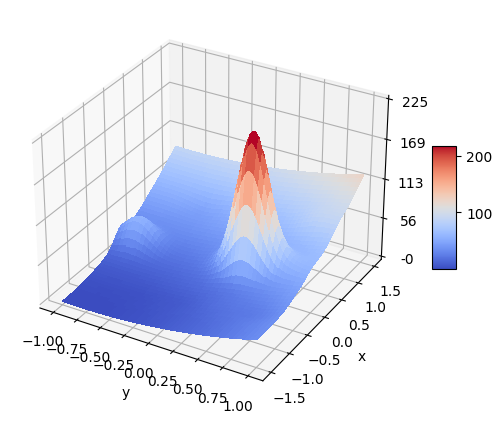

In [35]:
import matplotlib.pyplot as plt  # Importing the Matplotlib library for plotting
from matplotlib import cm  # Importing the color map module from Matplotlib
from matplotlib.ticker import LinearLocator  # Importing the LinearLocator module from Matplotlib
import numpy as np  # Importing NumPy library for numerical operations

fig = plt.figure(figsize=(20, 10))  # Creating a new figure with a specified size
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})  # Creating a 3D subplot within the figure
fig.figure.set_figheight(20)  # Setting the figure height

X_axis = np.linspace(-1.5, 1.5, 300)  # Generating X-axis values
Y_axis = np.linspace(-1, 1, 200)  # Generating Y-axis values
X, Y = np.meshgrid(Y_axis, X_axis)  # Creating a meshgrid for X and Y values

# Plotting the surface using the Cost_Map values with specified colormap and properties
surf = ax.plot_surface(X, Y, Cost_Map, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customizing the z-axis properties
# ax.set_zlim(-1.01, 1.01)  # Uncomment and customize if needed
ax.zaxis.set_major_locator(LinearLocator(5))  # Setting major locator for the z-axis
ax.zaxis.set_major_formatter('{x:.0f}')  # Setting major formatter for the z-axis

ax.set_xlabel('y')  # Labeling the x-axis
ax.set_ylabel('x')  # Labeling the y-axis

# Uncomment and customize if needed
# ax.view_init(90, 0)  # Setting the view angle for the 3D plot

# Adding a color bar to the plot
fig.colorbar(surf, shrink=0.08, aspect=5)

plt.show()  # Displaying the plot
# plt.savefig('Cost_Map_estimated.jpg', dpi=1000, bbox_inches='tight')  # Uncomment to save the plot as an image file


### Simulation with Reconstructed Cost

In [36]:
def Control_step(state, U_space_1, U_space_2, goal_points, obs_points, weights):
    target_pf = 1 / control_space_size**2  # Target probability density function (pf) for a uniform distribution
    time_step = 0.033  # Time step for the Robotarium simulation

    pf = np.zeros((control_space_size, control_space_size))  # Initialize the probability density function (pf)

    for i in range(control_space_size):
        for j in range(control_space_size):
            # Simulate the next state using the model_step function
            next_state = model_step(state, [U_space_1[i], U_space_2[j]], time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])  # Covariance matrix for the multivariate normal distribution
            f = st.multivariate_normal(next_state.reshape((2,)), cov)  # Create a multivariate normal distribution

            N_samples = 20  # Number of samples
            next_sample = f.rvs(N_samples)  # Generate random samples from the distribution

            cost = 0  # Initialize the cost variable

            # Calculate the estimated state cost for each sample and average them
            for k in range(N_samples):
                cost += state_cost_estimated(next_sample[k, :], goal_points, obs_points, weights) / N_samples

            # Calculate the log density ratio (log_DKL) for the current state 
            log_DKL = np.exp(-(-f.entropy()) - cost)
            pf[i, j] = log_DKL  # Update the probability density function (pf) matrix

    S2 = np.sum(pf)  # Calculate the sum of all probabilities in the pf matrix
    pf = np.divide(pf, S2)  # Normalize the pf matrix by dividing by the sum

    flat = pf.flatten()  # Flatten the pf matrix into a 1D array
    sample_index = np.random.choice(a=flat.size, p=flat)  # Choose an index based on the probability distribution

    adjusted_index = np.unravel_index(sample_index, pf.shape)  # Convert the flattened index to 2D indices
    action = np.reshape(np.array([U_space_1[adjusted_index[0]], U_space_2[adjusted_index[1]]]), (2, 1))

    return action  # Return the chosen action as a 2D array


Let's rerun the Robotarium cell to verify the correct functioning of our cost function, calculated via the IOC.

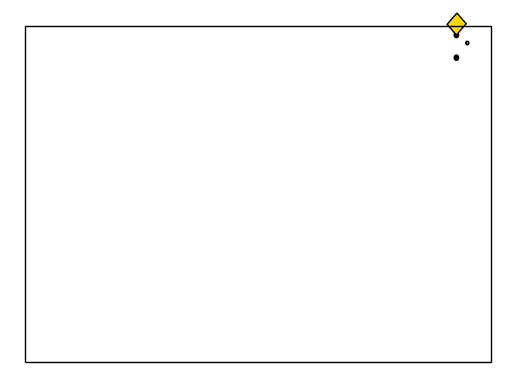

In [37]:
# Instantiate Robotarium object (start the robots from different initial conditions than the 4 experiments above)
N = 1
#initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]
#initial_conditions = [np.array(np.mat('-1.4;0.4; 0')),np.array(np.mat('0;-0.4; 0')),np.array(np.mat('-1.0;0.1; 0'))] #Initial pose of the robots
#initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('1.2;-0.2; 0')),np.array(np.mat('-1.2;0.8; 0')),np.array(np.mat('1.3;-0.5; 0')),np.array(np.mat('1.3;0.25; 0')),np.array(np.mat('0.3;0.9; 0'))] #Initial pose of the robots
#initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0'))] #Initial pose of the robots
#initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0'))]
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('1.2;0.2; 0')),np.array(np.mat('-1.2;0.8; 0')),np.array(np.mat('1.3;-0.9; 0')),np.array(np.mat('1.3;0.25; 0')),np.array(np.mat('-0.1;0.9; 0'))] #Initial pose of the robots
N_experiment = 6
# Definitions as above...
X_Si = [0]*N_experiment
D_Xi = [0]*N_experiment

# Iterate through the number of experiments
for I in range(N_experiment):
   # Initialize lists for states and actions during simulation
    X_si = []
    D_xi = []

    # Create a Robotarium object with initial conditions specific to the current iteration
    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

    # Create a single dynamic to single dynamic transformation function with backward motion
    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion()

    # Get the current positions of the robots
    x = r.get_poses()
   # Transform current positions from unique coordinates to standard coordinates
    x_si = uni_to_si_states(x)

    # Create an array of random colors for display purposes
    CM = np.random.rand(N + 10, 3)

    # Define marker sizes for display purposes
    goal_marker_size_m = 0.15
    obs_marker_size_m = 0.15

    # Determines the size and style of markers, text size, and line width
    marker_size_goal = determine_marker_size(r, goal_marker_size_m)
    marker_size_obs = determine_marker_size(r, obs_marker_size_m)
    font_size = determine_font_size(r, 0.1)
    line_width = 5

   # Create labels for target points
    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    # Create texts displayed near target points
    goal_points_text = [r.axes.text(goal_points[0, ii], goal_points[1, ii], goal_caption[ii], fontsize=font_size, color='k', fontweight='bold', horizontalalignment='center', verticalalignment='center', zorder=-2)
                        for ii in range(goal_points.shape[1])]
    # Crea marcatori per i punti obiettivo
    goal_markers = [r.axes.scatter(goal_points[0, ii], goal_points[1, ii], s=marker_size_goal, marker='s', facecolors='none', edgecolors=CM[ii, :], linewidth=line_width, zorder=-2)
                    for ii in range(goal_points.shape[1])]

    # Create labels for obstacle points
    obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    # Create texts displayed near obstacle points
    obs_points_text = [r.axes.text(obs_points[0, ii], obs_points[1, ii], obs_caption[ii], fontsize=font_size, color='k', fontweight='bold', horizontalalignment='center', verticalalignment='center', zorder=-2)
                       for ii in range(obs_points.shape[1])]
    # Create markers for obstacle points
    obs_markers = [r.axes.scatter(obs_points[0, ii], obs_points[1, ii], s=marker_size_obs, marker='s', facecolors='none', edgecolors=CM[ii + 1, :], linewidth=line_width, zorder=-2)
                   for ii in range(obs_points.shape[1])]

   # Advance one step in the simulation
    r.step()

    # Task: re-implement the simulation loop this time using the policy with the estimated cost
    i=0
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N and i<10000):

        # Get poses of agents
        x = r.get_poses()
        x_si = uni_to_si_states(x)

        #Add to the dataset
        X_si.append(x_si)

        # The lines below define the pdf of the robot 
        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
        x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
        x_sample = x_pdf.rvs() #Noisy state

        # This is about plotting
        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

        for j in range(obs_points.shape[1]):
            obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

        # Task: compute the action from the policy. Call the variable dxi: 
        # this is the action sampled from the optimal solution to the control problem
        dxi = Control_step(x_sample,U_space_1,U_space_2,goal_points,obs_points,weights)

        D_xi.append(dxi)

        # Transform single integrator velocity commands to unicycle inputs (low level controller)
        dxu = si_to_uni_dyn(dxi, x)

        # Set the velocities inputs
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        i=i+1
        r.step()
      

    D_Xi[I] = D_xi
    X_Si[I] = X_si

    r.call_at_scripts_end()

From the execution of the robotarium cell we observe that the new reconstructed cost allows the robot to perform its task

As we can see from the correct execution of the previous cell, the reconstructed cost still allows the robot to perform its task. As for the previous case, i.e. that of the cost function in the FOC, the robot is able to carry out its task, however through tests carried out with the same goal_point and obs_point data it was verified that the critical situations that occurred in the case precedent also occur with the rebuilt cost.

### Trajectories plot using Reconstructed Cost

In [ ]:
XX = X_Si
UU = D_Xi

In [ ]:
#Initialize empty lists X, X_plot, U, and U_plot to store arrays
X = []
X_plot = []
U = []
U_plot = []
#Iterate through each element in the list XX. Convert each element into a NumPy array and append it to both X and X_plot. 
# The purpose of appending to both lists is unclear; X and X_plot seem identical.
for i in range(len(XX)):
    X.append(np.array(XX[i]))
    X_plot.append(np.array(XX[i]))
#Concatenate the arrays in X along axis 0, resulting in a 2D array. Reshape the array to have two columns.
X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))
#Similar to the processing of XX, iterate through each element in the list UU. Convert each element into a NumPy array and append it to both U and U_plot. 
# As before, the purpose of appending to both lists is unclear.
U = []
for i in range(len(UU)):
    U.append(np.array(UU[i]))
    U_plot.append(np.array(UU[i]))
#Concatenate the arrays in U along axis 0, resulting in a 2D array. Reshape the array to have two columns
U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np


plt.plot(X_plot[0][:,0],X_plot[0][:,1],linewidth=2)
plt.plot(X_plot[1][:,0],X_plot[1][:,1],linewidth=2)
plt.plot(X_plot[2][:,0],X_plot[2][:,1],linewidth=2)
plt.plot(X_plot[3][:,0],X_plot[3][:,1],linewidth=2) 
plt.plot(X_plot[4][:,0],X_plot[4][:,1],linewidth=2)
plt.plot(X_plot[5][:,0],X_plot[5][:,1],linewidth=2)

square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black")
square3 = plt.Rectangle((-0.2,-1), 0.4, 0.4, fc='red',ec="black")
square2 = plt.Rectangle((-0.2,0), 0.4, 0.8, fc='red',ec="black")
plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

# WP5

### Weights Plot

In [ ]:
# Plotting feature points on the robotarium grid with correspopnding weights
#This code snippet creates a scatter plot of feature points on a grid, where each point is annotated with its corresponding weight. Let's break down the code:
import numpy as np
import matplotlib.pyplot as plt

# Create a scatter plot using obs_points_f
fig, ax = plt.subplots()

# Adjust the multiplier as needed
circle_sizes = np.abs(weights[:, 1:]) * 30
ax.scatter(obs_points_f[0, :], obs_points_f[1, :], circle_sizes)

# Initialize an array w of zeros
w = np.zeros((15,))

# Iterate through the weights and round each weight
for j in range(15):
    wt = float(weights[:, j + 1])
    w[j] = round(wt, 1)

# Annotate the scatter plot with the rounded weights
for i, txt in enumerate(w.reshape(15,)):
    # Add an offset to x to move the text to the right of the circle
    ax.annotate(txt, (obs_points_f[0, i] + 0.05, obs_points_f[1, i]), ha='left', va='center')

# Add a grid to the plot and display the final plot
plt.grid(True)
plt.show()


In [ ]:
weights

In [ ]:
# Comment the results you observe in the figure generated by the above cell

We observe that from the plot of the figure above, the weights of the features are very representative of the corresponding distance of the robot from the points representing the obstacles.
In particular, we note that these tend to increase as the robot gets closer to them. Which is why we can conclude that the weights of these features are sufficiently representative for these features.

### New Cost Function

The state_cost function want to evaluate how "costly" a certain state is in a given environment (that of the Robotarium), considering both goals to reach and obstacles to avoid. Let's analyze the function in detail:

## Input:

- **state**: A vector representing the current state. In this context, this is a vector containing the coordinates of the point in space.
goal_points: Coordinates of the goal point to reach, this a vector.
obs_points: A matrix containing the coordinates of obstacles in space. Each column represents the coordinates of a single obstacle.
Parameters and Variables:

- **v**: A vector of variances used to create a covariance matrix covar through np.diag(v).
gauss_sum: A variable initialized to zero that accumulates the sum of contributions from normal distributions (Gaussians) calculated for obstacles.
repulsion_term: A variable initialized to zero that accumulates the sum of repulsion terms calculated for obstacles.
covar: The covariance matrix for normal distributions, which is diagonal with variances given by v.
Calculation of the Gaussian Term:
The function uses a multivariate normal (Gaussian) distribution to model attraction towards obstacles. The sum of these distributions is calculated for each obstacle, and the output of each normal distribution is weighted with the value 15. This sum is assigned to gauss_sum.

- **Calculation of the Repulsion Term**:
The function calculates the repulsion term for each obstacle using the formula np.exp(distance_to_obstacle_i). This term is weighted with the value 3.5. The sum of all these terms is assigned to repulsion_term.

- **Calculation of the Attraction to the Goal Term**:
The term attracting towards the goal is calculated using the Euclidean distance between the current state and the goal point. This term is weighted with the value 70.

- **Calculation of the Specific Repulsion Term**:
Finally, there is a specific repulsion term for certain positions in space, representing the boundaries of the Robotarium environment in this case, with a weight of 1.

- **Final Cost Function**:
The total cost function is given by the sum of all these terms. In general, the function seeks to minimize the distance between the current state and the goal but penalizes proximity to obstacles. The specific form of the cost function and the weights associated with the various terms are designed to reflect the specific preferences of the motion planning or control problem under consideration.

## Choice between Gaussian Only (gauss_sum) and Gaussian + Repulsion (gauss_sum + repulsion_term):

### Using only gauss_sum:

- **Advantages**: Modeling obstacles as Gaussians can be smoother and more straightforward to optimize. It allows for finer control over the system's behavior during motion planning.
- **Disadvantages**: It might not fully capture the desired repulsion behaviors in the presence of obstacles. The Gaussian shape is generally broader and may not necessarily capture the exponential aspect of repulsion when approaching obstacles. This aspect was particularly relevant in our case, as using only the gauss_sum term for obstacles resulted in some situations where convergence was not achieved, and the system remained trapped in local minima. To describe an example, consider a scenario where the obstacle is positioned at the bottom, and the start point is to the right (left) of the obstacle, and the goal point is to the left (right). Once the robot aligned itself along the y-coordinate of the goal point, it remained stuck without circumnavigating the obstacle and, therefore, never reaching the destination.

### Using Gaussian + Repulsion (gauss_sum + repulsion_term):

- **Advantages**: Adding the repulsion term can ensure greater reactivity and stronger repulsion when the state approaches obstacles. This can be particularly useful for avoiding collisions more robustly. This aspect allowed us to overcome the critical scenario described above, leveraging a cost that specifically encouraged the robot to stay further away from obstacles.
- **Disadvantage**s: It may introduce additional complexity in parameter tuning. Using a simple Gaussian might be more intuitive to adjust.

Based on the above, it was deemed appropriate to use a combination of Gaussian modeling and exponential repulsion, especially based on the results obtained. This choice allowed us to address the identified issues in the original cost function effectively.

In [ ]:
def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar)
    
    repulsion_term = 0
    for i in range(np.size(obs_points, axis=1)):
        distance_to_obstacle_i = np.linalg.norm(state[:2] - obs_points[:2, i])
        repulsion_term += np.exp(distance_to_obstacle_i)
    
    cost = 100*np.sqrt((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 2.5*repulsion_term + 3*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
    + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
    + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi))) 
    
    return(cost)

### New Features


The choice to include a dedicated feature that takes into account the limits of the Robotarium environment is motivated by the following key points:

- **Relevance of Avoiding Environment Limits**:

    The specific nature of our application requires the system to avoid the limits of the Robotarium environment to ensure safe and efficient operation. This consideration led to viewing avoidance of the limits as a relevant component in reconstructing the cost function.

- **Enhancement of Cost Reconstruction Capability**:

    The addition of the dedicated feature was conceived to appropriately reconstruct the cost associated with obstacles and the limits of the environment. This is particularly significant in the context of inverse optimal control, where faithful cost reconstruction is crucial.

- **Validation through Simulations**:

    Validation through simulations has confirmed the effectiveness of our choice. This step is essential to ensure that the addition of the new feature indeed leads to improvements in the system's performance. Furthermore, our choice is motivated also by the fact that, with the old features, we note that sometimes the robot by using the reconstructed cost go out of the environment's boundaries.

In [ ]:

N_feature = np.size(obs_points_f,axis=1)+2 

def feature(next_state,goal_points,obs_points,N_feature): 

    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v) 
    features = np.zeros(N_feature) 
    
    for i in range(np.size(obs_points,axis=1)): 
        features[i+2] = my_logpdf(next_state[:2],obs_points[:2,i],covar) 

    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) 
    
    features[1] = np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
    + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
    + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
    + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
    

 
    return features 